# Import Statements

In [1]:
import pickle
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests
from collections import defaultdict

import re
from datetime import datetime
import glob

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Necessary imports
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

pd.set_option('display.max_columns', 500)

# Functions

In [2]:
def load_pickle(file_location):
    with open(file_location, "rb") as picklefile:
        df = pickle.load(picklefile)
    return(df)

# Clean Data

In [70]:
df = load_pickle("all_midtown_data.pkl")

In [71]:
# Remove Building Type column. They are all Condos
df = df.drop("Building Type", axis=1)

# Sort values by date sold
df = df.sort_values(by = 'sold_date_dt', ascending = False)

# Drop duplicate rows
#df_no_dup = df.drop_duplicates(subset = 'full_name', keep = 'first').reset_index(drop = True)
#print("1. Duplicates Removed")

# Add season
df['sold_season'] = (df['sold_date_dt']
                     .dt
                     .month
                     .map({1 : 'Winter', 
                           2 : 'Winter',
                           3 : 'Spring',
                           4 : 'Spring',
                           5 : 'Spring',
                           6 : 'Summer',
                           7 : 'Summer',
                           8 : 'Summer',
                           9 : 'Fall',
                           10 : 'Fall',
                           11 : 'Fall',
                           12 : 'Winter'}))
print("2. Season Added")

# Add days on market column, and convert datetime timedelta to float
df['days_on_market_1'] = df['sold_date_dt'] - df['Listed']
df['days_on_market_1'] = (df['days_on_market_1']/np.timedelta64(1, 'D'))
print("3. Days on Market Added")

# Fill to indicate Studio
df['beds'] = df['beds'].fillna(0)
print("4. Filled Beds to indicate Studio")

### Fixing rows where there is no condo ###
# Find where apt = NaN
df_apt_na = df[df['apt_floor'].isna()]

# Fill Apt nulls, move bldg address to correct place, and delete bldg name
for index, row in df_apt_na.iterrows():
    #print(row['apt_floor'])
    #print(np.isnan(row['apt_floor']))
    try:
        if np.isnan(row['apt_floor']):
            df.loc[index, 'apt_floor'] = int(re.findall('\d+', row['bldg_addr'])[0]) # assign value in full dataframe
            df.loc[index, 'bldg_addr'] = df.loc[index]['bldg_name'] # move building address over to correct column
            df.loc[index, 'bldg_name'] = np.nan # clears building name
            #print(index)
        else:
            continue
    except:
        continue
print("5. Apt Nulls Filled")

# Rename Columns
df = df.rename(columns = {"Listed": "listed", 
                 "Days on Market": "days_on_market", 
                 "Neighborhood": "neighborhood", 
                 "Monthly Common Charges": "monthly_common_charges", 
                 "Monthly Real Estate Taxes": "monthly_real_estate_taxes", 
                 "Minimum Down Payment": "minimum_down_payment", 
                 "Doorman": "doorman", 
                 "Last Price Change": "last_price_change"})
print("6. Renamed Columns")

2. Season Added
3. Days on Market Added
4. Filled Beds to indicate Studio
5. Apt Nulls Filled
6. Renamed Columns


In [88]:
#df_clean['year'] = df_clean['sold_date_dt'].apply(lambda x: x.strftime('%Y'))
df['year'] = df['sold_date_dt'].apply(lambda x: x.strftime('%Y'))

# Want only 2 bedrooms or less
df = df[df['beds'] < 2.5]

# Convert days on market to int
df['days_on_market'] = pd.to_numeric(df['days_on_market'])

In [89]:
df.shape

(22937, 25)

In [90]:
# 22945 values initially
# 15008 values once duplicates are dropped
df_drop = df.drop_duplicates(subset=['full_name', 'sold_date']).reset_index(drop = True)

In [91]:
df_drop.describe()
# Want apartments with only 0, 1, 2 bedrooms

,apt_floor,bldg_rating,sold_price,price_per_sqft,square_feet,beds,baths,days_on_market,monthly_common_charges,monthly_real_estate_taxes,minimum_down_payment,days_on_market_1
count,14978.000000,14392.000000,1.500300e+04,6445.000000,6445.000000,15003.000000,14975.000000,7083.000000,7.006000e+03,6707.000000,2856.000000,7083.000000
mean,159.778408,75.730753,1.315659e+06,1447.735764,951.232894,1.174498,1.459065,1789.009600,1.306234e+03,937.680781,0.109436,47.166173
std,630.924406,11.085550,1.224740e+06,550.755976,384.575335,0.688777,0.565285,1052.018098,1.707124e+04,1114.621562,0.055149,835.310532
min,1.000000,44.000000,1.000000e+05,190.000000,285.000000,0.000000,1.000000,2.000000,2.060000e+02,101.000000,0.100000,-6004.000000
25%,7.000000,68.000000,6.890000e+05,1099.000000,668.000000,1.000000,1.000000,895.500000,6.490000e+02,523.000000,0.100000,48.000000
50%,16.000000,78.000000,9.850000e+05,1338.000000,878.000000,1.000000,1.000000,1689.000000,8.850000e+02,773.000000,0.100000,126.000000
75%,32.000000,84.000000,1.540000e+06,1650.000000,1176.000000,2.000000,2.000000,2562.000000,1.301750e+03,1152.000000,0.100000,237.000000
max,6504.000000,99.000000,2.200000e+07,6705.000000,3895.000000,2.000000,5.000000,4517.000000,1.426830e+06,75980.000000,0.900000,3706.000000


In [77]:
## Trying something. Seeing how many duplicates I have
df_drop.head()

,full_name,bldg_name,bldg_addr,apt_floor,bldg_rating,sold_date,sold_date_dt,sold_price,price_per_sqft,square_feet,bed_and_bath,beds,baths,url,listed,days_on_market,neighborhood,monthly_common_charges,monthly_real_estate_taxes,minimum_down_payment,doorman,last_price_change,sold_season,days_on_market_1,year
0,"Worldwide Plaza, 393 West 49th Street, #3P",Worldwide Plaza,393 West 49th Street,3.0,73.0,"Last Sold on Sep 27, 2019",2019-09-27,545000.0,NaN,NaN,"Studio, 1 bath",0.0,1.0,https://www.cityrealty.com/nyc/midtown-west/worldwide-plaza-393-west-49th-street/apartment-3P/sold/A6336,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,NaN,2019
1,"The Cosmopolitan, 145 East 48th Street, #25G",The Cosmopolitan,145 East 48th Street,25.0,78.0,"Last Sold on Sep 25, 2019",2019-09-25,799000.0,1229.0,650.0,"1 bed, 1 bath",1.0,1.0,https://www.cityrealty.com/nyc/midtown-east/the-cosmopolitan-145-east-48th-street/apartment-25G/sold/A4324,2019-04-12,177,Midtown East,814.0,948.0,0.1,FT Doorman,NaN,Fall,166.0,2019
2,"The Orion, 350 West 42nd Street, #21F",The Orion,350 West 42nd Street,21.0,79.0,"Last Sold on Sep 24, 2019",2019-09-24,1085000.0,1572.0,690.0,"1 bed, 1 bath",1.0,1.0,https://www.cityrealty.com/nyc/midtown-west/the-orion-350-west-42nd-street/apartment-21F/sold/A27644,2019-04-12,176,Midtown West,689.0,1315.0,NaN,FT Doorman,NaN,Fall,165.0,2019
3,"Morgan Court, 211 Madison Avenue, #6A",Morgan Court,211 Madison Avenue,6.0,73.0,"Last Sold on Sep 23, 2019",2019-09-23,1039000.0,910.0,1142.0,"1 bed, 1.5 baths",1.0,1.5,https://www.cityrealty.com/nyc/murray-hill/morgan-court-211-madison-avenue/apartment-6A/sold/A164244,2019-03-06,214,Murray Hill,1683.0,1148.0,NaN,FT Doorman,NaN,Fall,201.0,2019
4,"325 Fifth Avenue, #23F",NaN,325 Fifth Avenue,23.0,70.0,"Last Sold on Sep 23, 2019",2019-09-23,1080000.0,1570.0,688.0,"1 bed, 1 bath",1.0,1.0,https://www.cityrealty.com/nyc/murray-hill/325-fifth-avenue/apartment-23F/sold/A122716,2019-05-28,132,Murray Hill,810.0,1511.0,NaN,FT Doorman,NaN,Fall,118.0,2019


# Investigating Days on Market -- won't include

In [65]:
pd.options.display.max_colwidth = 200

In [94]:
df_drop[['full_name', 'sold_date_dt', 'listed', 'days_on_market', 'days_on_market_1', 'url']].describe()

,days_on_market,days_on_market_1
count,7083.000000,7083.000000
mean,1789.009600,47.166173
std,1052.018098,835.310532
min,2.000000,-6004.000000
25%,895.500000,48.000000
50%,1689.000000,126.000000
75%,2562.000000,237.000000
max,4517.000000,3706.000000


In [93]:
df_drop[df_drop['days_on_market_1'] < df_drop['days_on_market']]

,full_name,bldg_name,bldg_addr,apt_floor,bldg_rating,sold_date,sold_date_dt,sold_price,price_per_sqft,square_feet,bed_and_bath,beds,baths,url,listed,days_on_market,neighborhood,monthly_common_charges,monthly_real_estate_taxes,minimum_down_payment,doorman,last_price_change,sold_season,days_on_market_1,year
1,"The Cosmopolitan, 145 East 48th Street, #25G",The Cosmopolitan,145 East 48th Street,25.0,78.0,"Last Sold on Sep 25, 2019",2019-09-25,799000.0,1229.0,650.0,"1 bed, 1 bath",1.0,1.0,https://www.cityrealty.com/nyc/midtown-east/the-cosmopolitan-145-east-48th-street/apartment-25G/sold/A4324,2019-04-12,177.0,Midtown East,814.0,948.0,0.1,FT Doorman,NaN,Fall,166.0,2019
2,"The Orion, 350 West 42nd Street, #21F",The Orion,350 West 42nd Street,21.0,79.0,"Last Sold on Sep 24, 2019",2019-09-24,1085000.0,1572.0,690.0,"1 bed, 1 bath",1.0,1.0,https://www.cityrealty.com/nyc/midtown-west/the-orion-350-west-42nd-street/apartment-21F/sold/A27644,2019-04-12,176.0,Midtown West,689.0,1315.0,NaN,FT Doorman,NaN,Fall,165.0,2019
3,"Morgan Court, 211 Madison Avenue, #6A",Morgan Court,211 Madison Avenue,6.0,73.0,"Last Sold on Sep 23, 2019",2019-09-23,1039000.0,910.0,1142.0,"1 bed, 1.5 baths",1.0,1.5,https://www.cityrealty.com/nyc/murray-hill/morgan-court-211-madison-avenue/apartment-6A/sold/A164244,2019-03-06,214.0,Murray Hill,1683.0,1148.0,NaN,FT Doorman,NaN,Fall,201.0,2019
4,"325 Fifth Avenue, #23F",NaN,325 Fifth Avenue,23.0,70.0,"Last Sold on Sep 23, 2019",2019-09-23,1080000.0,1570.0,688.0,"1 bed, 1 bath",1.0,1.0,https://www.cityrealty.com/nyc/murray-hill/325-fifth-avenue/apartment-23F/sold/A122716,2019-05-28,132.0,Murray Hill,810.0,1511.0,NaN,FT Doorman,NaN,Fall,118.0,2019
5,"The Parc Vendome, 350 West 57th Street, #10I",The Parc Vendome,350 West 57th Street,10.0,82.0,"Last Sold on Sep 23, 2019",2019-09-23,1400000.0,1167.0,1200.0,"1 bed, 1 bath",1.0,1.0,https://www.cityrealty.com/nyc/midtown-west/the-parc-vendome-350-west-57th-street/apartment-10I/sold/A239210,2019-06-06,121.0,Midtown West,1676.0,1211.0,NaN,FT Doorman,NaN,Fall,109.0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14766,"The Park Imperial, 230 West 56th Street, #56C",The Park Imperial,230 West 56th Street,56.0,82.0,"Last Sold on Jun 13, 2003",2003-06-13,1435733.0,NaN,NaN,"2 beds, 2 baths",2.0,2.0,https://www.cityrealty.com/nyc/midtown-west/the-park-imperial-230-west-56th-street/apartment-56C/sold/A6069,2019-07-24,75.0,Midtown West,2081.0,1994.0,NaN,FT Doorman,"-0.8%\n\n($25,000)\non\nSep 3",Summer,-5885.0,2003
14849,"The Park Imperial, 230 West 56th Street, #54E",The Park Imperial,230 West 56th Street,54.0,82.0,"Last Sold on May 2, 2003",2003-05-02,1338999.0,NaN,NaN,"2 beds, 2 baths",2.0,2.0,https://www.cityrealty.com/nyc/midtown-west/the-park-imperial-230-west-56th-street/apartment-54E/sold/A6059,2019-09-10,27.0,Midtown West,1775.0,1623.0,NaN,FT Doorman,NaN,Spring,-5975.0,2003
14910,"The Lausanne, 333 East 45th Street, #22C",The Lausanne,333 East 45th Street,22.0,62.0,"Last Sold on Mar 24, 2003",2003-03-24,355000.0,NaN,NaN,"1 bed, 1 bath",1.0,1.0,https://www.cityrealty.com/nyc/turtle-bay-united-nations/the-lausanne-333-east-45th-street/apartment-22C/sold/A5398,2019-07-11,88.0,Turtle Bay/United Nations,555.0,785.0,0.1,FT Doorman,NaN,Spring,-5953.0,2003
14917,"Trump Parc, 106 Central Park South, #21J",Trump Parc,106 Central Park South,21.0,83.0,"Last Sold on Mar 19, 2003",2003-03-19,315000.0,NaN,NaN,"Studio, 1 bath",0.0,1.0,https://www.cityrealty.com/nyc/midtown-west/trump-parc-106-central-park-south/apartment-21J/sold/A5999,2019-08-26,42.0,Midtown West,725.0,NaN,0.1,FT Doorman,NaN,Spring,-6004.0,2003


In [85]:
df_drop[df_drop['days_on_market_1'] > 1000]

,full_name,bldg_name,bldg_addr,apt_floor,bldg_rating,sold_date,sold_date_dt,sold_price,price_per_sqft,square_feet,bed_and_bath,beds,baths,url,listed,days_on_market,neighborhood,monthly_common_charges,monthly_real_estate_taxes,minimum_down_payment,doorman,last_price_change,sold_season,days_on_market_1,year
13,"1600 Broadway, #PH3B",NaN,1600 Broadway,3.0,73.0,"Last Sold on Sep 18, 2019",2019-09-18,1295000.0,1439.0,900.0,"2 beds, 1 bath",2.0,1.0,https://www.cityrealty.com/nyc/midtown-west/1600-broadway/apartment-PH3B/sold/A121793,2009-09-16,3673,Midtown West,1075.0,575.0,NaN,FT Doorman,NaN,Fall,3654.0,2019
31,"The Parc Vendome, 353 West 56th Street, #4I",The Parc Vendome,353 West 56th Street,4.0,75.0,"Last Sold on Sep 10, 2019",2019-09-10,1100000.0,1182.0,931.0,"1 bed, 1 bath",1.0,1.0,https://www.cityrealty.com/nyc/midtown-west/the-parc-vendome-353-west-56th-street/apartment-4I/sold/A271844,2014-01-08,2096,Midtown West,1117.0,855.0,0.2,FT Doorman,NaN,Fall,2071.0,2019
43,"Worldwide Plaza, 393 West 49th Street, #6II",Worldwide Plaza,393 West 49th Street,6.0,73.0,"Last Sold on Sep 4, 2019",2019-09-04,575000.0,NaN,NaN,"Studio, 1 bath",0.0,1.0,https://www.cityrealty.com/nyc/midtown-west/worldwide-plaza-393-west-49th-street/apartment-6II/sold/A12438,2009-07-12,3739,Midtown West,619.0,326.0,0.1,FT Doorman,NaN,Fall,3706.0,2019
55,"Atelier, 635 West 42nd Street, #32D",Atelier,635 West 42nd Street,32.0,81.0,"Last Sold on Aug 28, 2019",2019-08-28,1590000.0,1563.0,1017.0,"2 beds, 2 baths",2.0,2.0,https://www.cityrealty.com/nyc/midtown-west/atelier-635-west-42nd-street/apartment-32D/sold/A146379,2015-03-18,1662,Midtown West,816.0,799.0,NaN,FT Doorman,NaN,Summer,1624.0,2019
56,"Manhattan View at MiMa, 460 West 42nd Street, #54D",Manhattan View at MiMa,460 West 42nd Street,54.0,86.0,"Last Sold on Aug 27, 2019",2019-08-27,2900000.0,2551.0,1137.0,"2 beds, 2 baths",2.0,2.0,https://www.cityrealty.com/nyc/midtown-west/manhattan-view-mima-460-west-42nd-street/apartment-54D/sold/A269106,2016-06-15,1207,Midtown West,1510.0,888.0,NaN,FT Doorman,NaN,Summer,1168.0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9064,"Number 5, 5 East 44th Street, #17",Number 5,5 East 44th Street,17.0,72.0,"Last Sold on Sep 7, 2010",2010-09-07,1395000.0,1092.0,1277.0,"2 beds, 2 baths",2.0,2.0,https://www.cityrealty.com/nyc/midtown-east/number-5-5-east-44th-street/apartment-17/sold/A145093,2007-06-07,4504,Midtown East,1211.0,453.0,NaN,NaN,NaN,Fall,1188.0,2010
9147,"Number 5, 5 East 44th Street, #4B",Number 5,5 East 44th Street,4.0,72.0,"Last Sold on Jul 29, 2010",2010-07-29,670000.0,1065.0,629.0,"1 bed, 1 bath",1.0,1.0,https://www.cityrealty.com/nyc/midtown-east/number-5-5-east-44th-street/apartment-4B/sold/A145086,2007-05-25,4517,Midtown East,503.0,250.0,NaN,NaN,NaN,Summer,1161.0,2010
9160,"Number 5, 5 East 44th Street, #16",Number 5,5 East 44th Street,16.0,72.0,"Last Sold on Jul 26, 2010",2010-07-26,1295000.0,1014.0,1277.0,"2 beds, 2 baths",2.0,2.0,https://www.cityrealty.com/nyc/midtown-east/number-5-5-east-44th-street/apartment-16/sold/A145092,2007-05-25,4517,Midtown East,1020.0,507.0,NaN,NaN,NaN,Summer,1158.0,2010
9294,"Number 5, 5 East 44th Street, #8",Number 5,5 East 44th Street,8.0,72.0,"Last Sold on May 27, 2010",2010-05-27,1550000.0,1095.0,1416.0,"2 beds, 2 baths",2.0,2.0,https://www.cityrealty.com/nyc/midtown-east/number-5-5-east-44th-street/apartment-8/sold/A145089,2007-05-25,4517,Midtown East,1131.0,561.0,NaN,NaN,NaN,Spring,1098.0,2010


In [67]:
df_drop[['full_name', 'sold_date_dt', 'listed', 'days_on_market', 'url']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15003 entries, 0 to 15002
Data columns (total 6 columns):
full_name         15003 non-null object
sold_date_dt      15003 non-null datetime64[ns]
listed            7083 non-null datetime64[ns]
days_on_market    7083 non-null object
days_on_market    7083 non-null float64
url               15003 non-null object
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 703.4+ KB


# EDA

In [506]:
target = ['sold_price']
bldg = ['full_name'] #'bldg_name', 'bldg_addr']
cont = ['bldg_rating', 
        'square_feet', 
        'beds', 
        'baths', 
        'monthly_common_charges', 
        'monthly_real_estate_taxes']
cat = ['sold_season', 'neighborhood', 'year']
model_columns = bldg + cont + cat + target

In [507]:
smaller_df = df_drop.loc[:, model_columns]
#smaller_df.shape
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15003 entries, 0 to 15002
Data columns (total 11 columns):
full_name                    15003 non-null object
bldg_rating                  14392 non-null float64
square_feet                  6445 non-null float64
beds                         15003 non-null float64
baths                        14975 non-null float64
monthly_common_charges       7006 non-null float64
monthly_real_estate_taxes    6707 non-null float64
sold_season                  15003 non-null object
neighborhood                 7083 non-null object
year                         15003 non-null object
sold_price                   15003 non-null float64
dtypes: float64(7), object(4)
memory usage: 1.3+ MB


In [508]:
# Drop NAs
smaller_df = smaller_df.dropna().reset_index(drop = True)
# smaller_df.head()

In [509]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5054 entries, 0 to 5053
Data columns (total 11 columns):
full_name                    5054 non-null object
bldg_rating                  5054 non-null float64
square_feet                  5054 non-null float64
beds                         5054 non-null float64
baths                        5054 non-null float64
monthly_common_charges       5054 non-null float64
monthly_real_estate_taxes    5054 non-null float64
sold_season                  5054 non-null object
neighborhood                 5054 non-null object
year                         5054 non-null object
sold_price                   5054 non-null float64
dtypes: float64(7), object(4)
memory usage: 434.5+ KB


In [510]:
smaller_df.describe()

,bldg_rating,square_feet,beds,baths,monthly_common_charges,monthly_real_estate_taxes,sold_price
count,5054.000000,5054.000000,5054.000000,5054.000000,5054.000000,5054.000000,5.054000e+03
mean,76.295607,960.371389,1.229323,1.514345,1133.755441,938.881678,1.539079e+06
std,10.695157,390.201667,0.678938,0.581513,1192.362110,1228.879762,1.252664e+06
min,44.000000,285.000000,0.000000,1.000000,216.000000,101.000000,1.715180e+05
25%,70.000000,678.000000,1.000000,1.000000,680.000000,516.000000,8.400000e+05
50%,78.000000,884.000000,1.000000,1.500000,917.500000,773.500000,1.200000e+06
75%,84.000000,1186.000000,2.000000,2.000000,1355.000000,1162.000000,1.795000e+06
max,99.000000,3895.000000,2.000000,3.500000,64560.000000,75980.000000,2.200000e+07


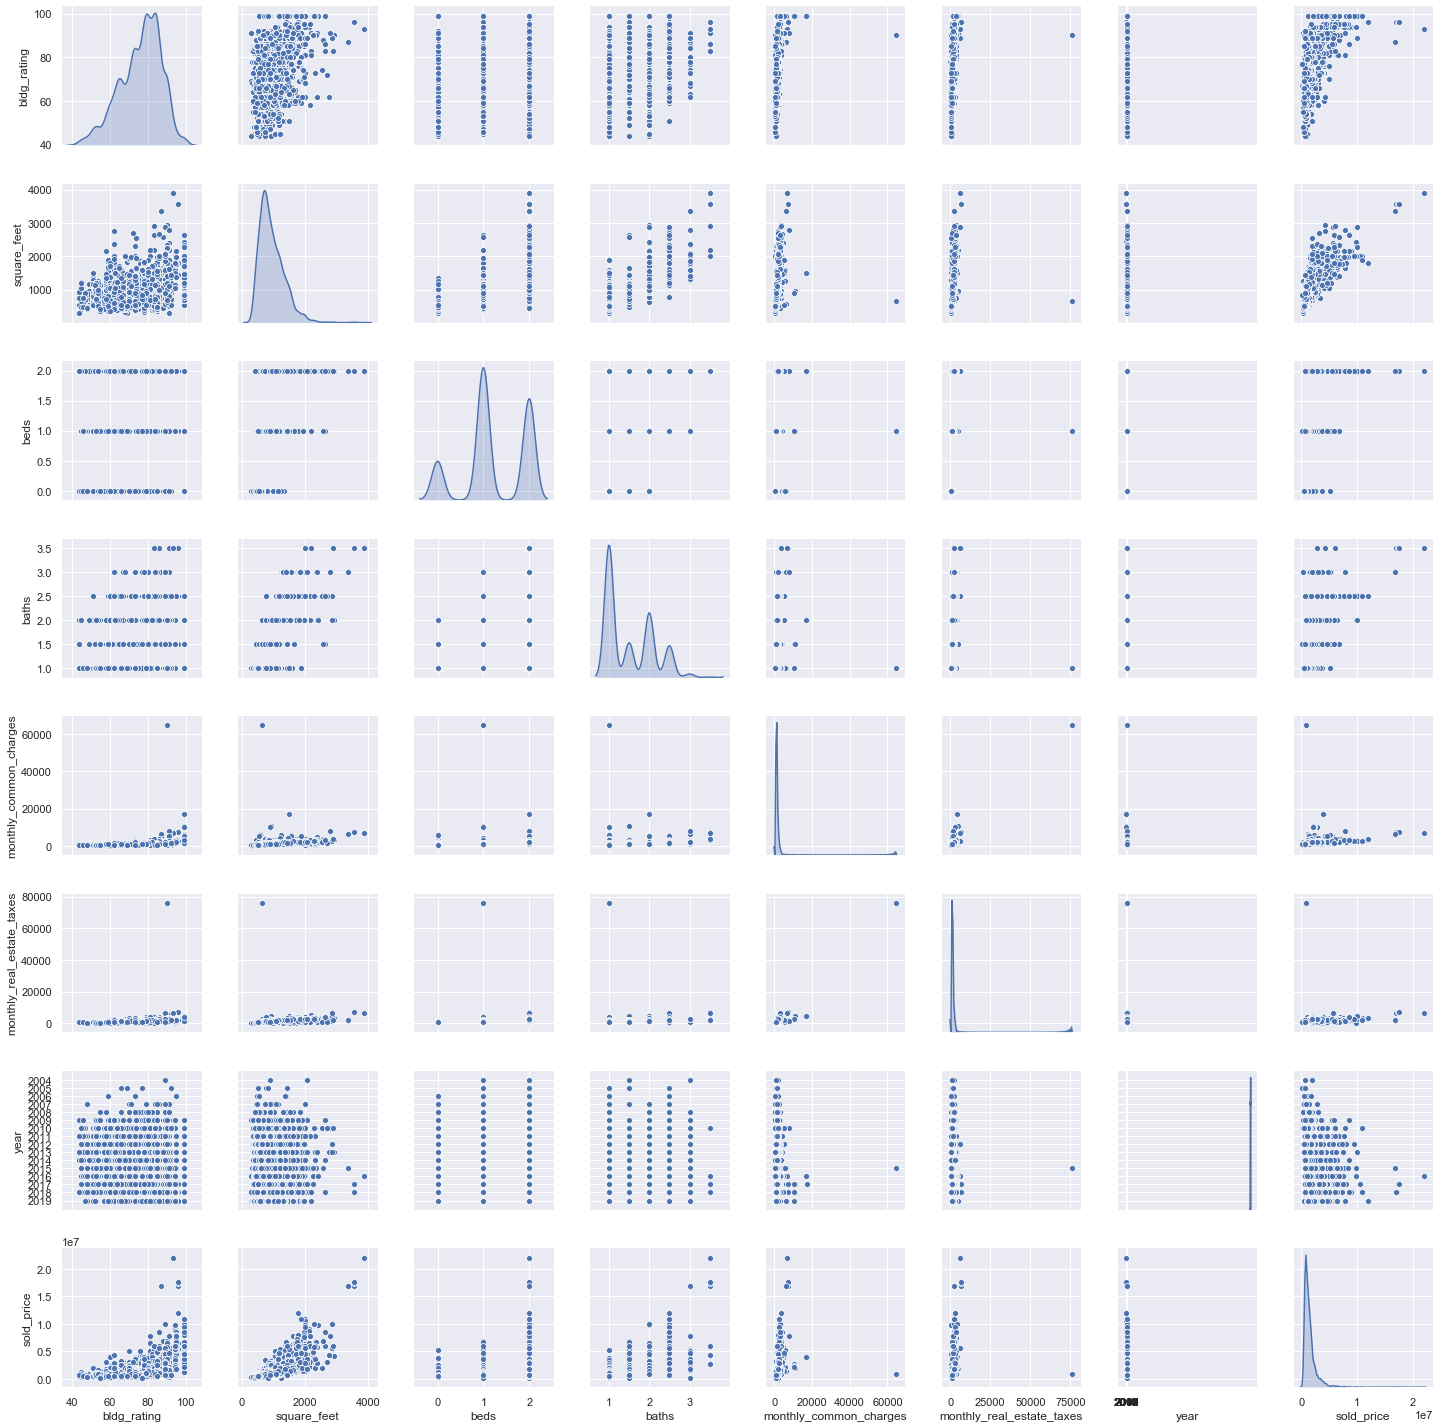

In [511]:
sns.pairplot(smaller_df, diag_kind='kde')

In [513]:
smaller_df.corr()

,bldg_rating,square_feet,beds,baths,monthly_common_charges,monthly_real_estate_taxes,sold_price
bldg_rating,1.000000,0.318719,0.141351,0.293083,0.242399,0.168293,0.391198
square_feet,0.318719,1.000000,0.746558,0.836892,0.436232,0.348710,0.787349
beds,0.141351,0.746558,1.000000,0.765608,0.282787,0.233872,0.481830
baths,0.293083,0.836892,0.765608,1.000000,0.349362,0.275434,0.615768
monthly_common_charges,0.242399,0.436232,0.282787,0.349362,1.000000,0.864413,0.450711
monthly_real_estate_taxes,0.168293,0.348710,0.233872,0.275434,0.864413,1.000000,0.345680
sold_price,0.391198,0.787349,0.481830,0.615768,0.450711,0.345680,1.000000


In [514]:
# Remove outliers. 21 outliers greater than 8 Million
smaller_df_no_out = smaller_df[smaller_df['sold_price'] < 6000000]

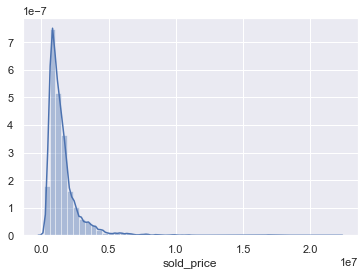

In [515]:
sns.distplot(smaller_df['sold_price'] )

In [516]:
smaller_df_no_out.head()

,full_name,bldg_rating,square_feet,beds,baths,monthly_common_charges,monthly_real_estate_taxes,sold_season,neighborhood,year,sold_price
0,"The Cosmopolitan, 145 East 48th Street, #25G",78.0,650.0,1.0,1.0,814.0,948.0,Fall,Midtown East,2019,799000.0
1,"The Orion, 350 West 42nd Street, #21F",79.0,690.0,1.0,1.0,689.0,1315.0,Fall,Midtown West,2019,1085000.0
2,"Morgan Court, 211 Madison Avenue, #6A",73.0,1142.0,1.0,1.5,1683.0,1148.0,Fall,Murray Hill,2019,1039000.0
3,"325 Fifth Avenue, #23F",70.0,688.0,1.0,1.0,810.0,1511.0,Fall,Murray Hill,2019,1080000.0
4,"The Parc Vendome, 350 West 57th Street, #10I",82.0,1200.0,1.0,1.0,1676.0,1211.0,Fall,Midtown West,2019,1400000.0


In [517]:
# Get Dummies
df_model = pd.get_dummies(smaller_df_no_out.drop('full_name', axis = 1), columns = ['sold_season', 'neighborhood'])

# Remove large outliers from sold

df_model.head()

,bldg_rating,square_feet,beds,baths,monthly_common_charges,monthly_real_estate_taxes,year,sold_price,sold_season_Fall,sold_season_Spring,sold_season_Summer,sold_season_Winter,neighborhood_Beekman/Sutton Place,neighborhood_Midtown East,neighborhood_Midtown West,neighborhood_Murray Hill,neighborhood_Turtle Bay/United Nations
0,78.0,650.0,1.0,1.0,814.0,948.0,2019,799000.0,1,0,0,0,0,1,0,0,0
1,79.0,690.0,1.0,1.0,689.0,1315.0,2019,1085000.0,1,0,0,0,0,0,1,0,0
2,73.0,1142.0,1.0,1.5,1683.0,1148.0,2019,1039000.0,1,0,0,0,0,0,0,1,0
3,70.0,688.0,1.0,1.0,810.0,1511.0,2019,1080000.0,1,0,0,0,0,0,0,1,0
4,82.0,1200.0,1.0,1.0,1676.0,1211.0,2019,1400000.0,1,0,0,0,0,0,1,0,0


In [518]:
len(df_model.columns)

17

In [519]:
len(df_model)

4993

In [520]:
# Define X values and y values
X = df_model.drop('sold_price', axis = 1)
y = df_model['sold_price']

In [521]:
df_model.head()

,bldg_rating,square_feet,beds,baths,monthly_common_charges,monthly_real_estate_taxes,year,sold_price,sold_season_Fall,sold_season_Spring,sold_season_Summer,sold_season_Winter,neighborhood_Beekman/Sutton Place,neighborhood_Midtown East,neighborhood_Midtown West,neighborhood_Murray Hill,neighborhood_Turtle Bay/United Nations
0,78.0,650.0,1.0,1.0,814.0,948.0,2019,799000.0,1,0,0,0,0,1,0,0,0
1,79.0,690.0,1.0,1.0,689.0,1315.0,2019,1085000.0,1,0,0,0,0,0,1,0,0
2,73.0,1142.0,1.0,1.5,1683.0,1148.0,2019,1039000.0,1,0,0,0,0,0,0,1,0
3,70.0,688.0,1.0,1.0,810.0,1511.0,2019,1080000.0,1,0,0,0,0,0,0,1,0
4,82.0,1200.0,1.0,1.0,1676.0,1211.0,2019,1400000.0,1,0,0,0,0,0,1,0,0


In [585]:
# weird = 10, 14
# normal = 11, 12, 13
rs = 14

In [586]:
# hold out 20% of the data for final testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state= rs)

In [524]:
X_train.shape, y_train.shape

((3994, 16), (3994,))

In [525]:
X_test.shape, y_test.shape

((999, 16), (999,))

# Looking at different random states

In [526]:
sns.distplot(X['apt_floor'][X['apt_floor'] < 100])

KeyError: 'apt_floor'

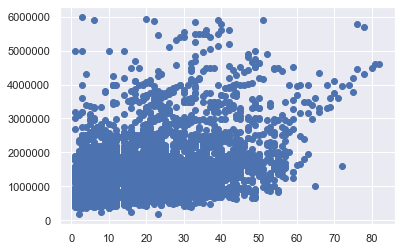

In [406]:
plt.scatter(smaller_df_no_out['apt_floor'][smaller_df_no_out['apt_floor'] < 100], smaller_df_no_out['sold_price'][smaller_df_no_out['apt_floor'] < 100])

In [355]:
rs_10 = 10 #weird
rs_14 = 14 #weird
rs_11 = 11 #normal
X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=.2, random_state= rs_10)
X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=.2, random_state= rs_14)
X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=.2, random_state= rs_11)

In [377]:
smaller_df_no_out.columns

Index(['full_name', 'bldg_rating', 'apt_floor', 'square_feet', 'beds', 'baths',
       'monthly_common_charges', 'monthly_real_estate_taxes', 'sold_season',
       'neighborhood', 'year', 'sold_price'],
      dtype='object')

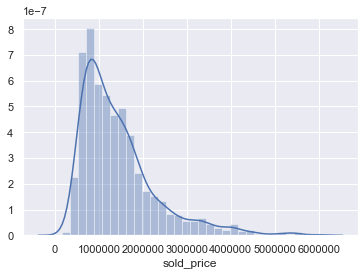

In [497]:
sns.distplot(y_test14)

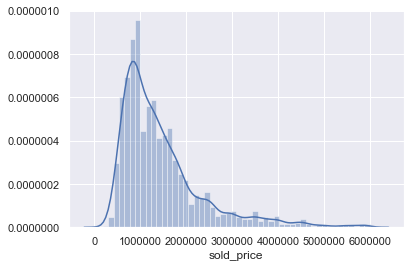

In [498]:
sns.distplot(y_train14)

In [499]:
# 14 is weird
smaller_df_no_out.loc[list(X_train14.index), :]['baths'].value_counts()
#smaller_df_no_out.loc[list(X_train14.index), :]['monthly_common_charges'].mean()

1.0    2018
2.0     967
1.5     515
2.5     438
3.0      50
3.5       2
Name: baths, dtype: int64

In [440]:
smaller_df_no_out['neighborhood'].value_counts()

Midtown West                 2502
Murray Hill                  1168
Midtown East                  634
Turtle Bay/United Nations     552
Beekman/Sutton Place          132
Name: neighborhood, dtype: int64

In [441]:
smaller_df_no_out['sold_season'].value_counts()

Summer    1484
Spring    1196
Fall      1158
Winter    1150
Name: sold_season, dtype: int64

In [442]:
smaller_df_no_out['year'].value_counts()

2017    658
2016    570
2015    561
2018    549
2013    536
2014    484
2012    455
2019    354
2011    346
2010    292
2009    147
2008     16
2007     10
2005      4
2006      4
2004      2
Name: year, dtype: int64

In [500]:
smaller_df_no_out.loc[list(X_test14.index), :]['baths'].value_counts()
#smaller_df_no_out.loc[list(X_test14.index), :]['monthly_common_charges'].mean()

1.0    484
2.0    247
1.5    135
2.5    118
3.0     13
3.5      1
Name: baths, dtype: int64

In [371]:
#smaller_df_no_out.loc[list(X_test14.index), :]['year'].value_counts()

In [373]:
#smaller_df_no_out.loc[list(X_train14.index), :]['sold_season'].value_counts()

In [418]:
smaller_df_no_out.loc[list(X_train11.index), :]['beds'].value_counts()
#smaller_df_no_out.loc[list(X_train11.index), :]['monthly_common_charges'].mean()

1.0    1969
2.0    1456
0.0     565
Name: beds, dtype: int64

In [417]:
smaller_df_no_out.loc[list(X_test11.index), :]['beds'].value_counts()

1.0    483
2.0    362
0.0    153
Name: beds, dtype: int64

# Simple Model - 1 Variable

In [22]:
#sns.distplot(df_model['sold_price'][df_model['sold_price'] <10000000])
#plt.scatter(df_model['sold_price'])

In [429]:
column_1 = ['square_feet','monthly_common_charges', 'monthly_real_estate_taxes', 'beds', 'baths', 'apt_floor'] # 'beds', 'baths', 
one_col_model = LinearRegression()
one_col_model.fit(X_train.loc[:, column_1], y_train)
one_col_model.score(X_train.loc[:, column_1], y_train)
#one_col_model.coef_, one_col_model.intercept_

0.6756708541596688

In [430]:
one_col_model.score(X_test.loc[:, column_1],y_test)

0.6721261231371783

In [432]:
cross_val_score(X_train.loc[:, column_1], y_train, cv = 5, scoring = 'r2')

TypeError: estimator should be an estimator implementing 'fit' method,       square_feet  monthly_common_charges  monthly_real_estate_taxes  beds  \
3080        663.0                   663.0                      422.0   1.0   
3214        840.0                  1101.0                      591.0   1.0   
1631        991.0                  1289.0                      783.0   1.0   
2453       1040.0                  1475.0                     1317.0   2.0   
3479       1250.0                  1767.0                     1046.0   2.0   
...           ...                     ...                        ...   ...   
336        1970.0                  3278.0                     3164.0   2.0   
1317        763.0                   607.0                      791.0   1.0   
4077        675.0                   618.0                      595.0   1.0   
3825        622.0                   447.0                      440.0   1.0   
1973        958.0                   751.0                      561.0   1.0   

      baths  apt_floor  
3080    1.0        6.0  
3214    1.5       15.0  
1631    1.5        3.0  
2453    2.0       35.0  
3479    2.0        6.0  
...     ...        ...  
336     2.5       17.0  
1317    1.0       35.0  
4077    1.0        8.0  
3825    1.0        6.0  
1973    1.5       23.0  

[3990 rows x 6 columns] was passed

# Comparing Simple Models

In [178]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [587]:
# Models

lm = LinearRegression()
lm_reg = Ridge(alpha = 10)

kf = KFold(n_splits=20, shuffle=True, random_state = 1001)

In [588]:
# Linear Regression
print(np.mean(cross_val_score(lm, X_train, y_train, # estimator, features, target
                cv=kf, # number of folds 
                scoring='r2'))) # scoring metric
print(cross_val_score(lm, X_train, y_train, # estimator, features, target
                cv=kf, # number of folds 
                scoring='r2'))

0.5716389053029579
[ 0.74606343  0.6753789   0.71514762  0.76639392  0.6991305   0.78227049
  0.71987565  0.69773214  0.78792715  0.77017454  0.78162686  0.73229477
  0.73311486  0.7804499   0.79098933  0.64310856  0.72115338 -2.55992632
  0.72130197  0.72857044]


In [581]:
# Ridge Regression
np.mean(cross_val_score(lm_reg, X_train, y_train, # estimator, features, target
                cv=kf, # number of folds 
                scoring='r2')) # scoring metric
print(cross_val_score(lm_reg, X_train, y_train, # estimator, features, target
                cv=kf, # number of folds 
                scoring='r2'))

[ 0.80673346  0.68378401  0.74573084  0.6698707   0.75014506  0.66148102
 -3.31276823  0.77584847  0.79757068  0.71047463  0.79708105  0.64997449
  0.74245974  0.68909583  0.75422447  0.73630993  0.76902328  0.76260286
  0.67590705  0.74869043]


In [589]:
# Linear Regression. Compare Train and Test
lm.fit(X_train, y_train)
print("Train Score: ", lm.score(X_train, y_train))
print("Test Score: ", lm.score(X_test, y_test))

Train Score:  0.7371255063842258
Test Score:  0.7462972051449941


In [584]:
# Ridge Regression. Compare Train and Test
lm_reg.fit(X_train, y_train)
print("Train Score: ", lm_reg.score(X_train, y_train))
print("Test Score: ", lm_reg.score(X_test, y_test))

Train Score:  0.7368477121000645
Test Score:  0.7469781850417081


# Ridge Regression with Standard Scaler

In [542]:
X_train.head()

,bldg_rating,square_feet,beds,baths,monthly_common_charges,monthly_real_estate_taxes,year,sold_season_Fall,sold_season_Spring,sold_season_Summer,sold_season_Winter,neighborhood_Beekman/Sutton Place,neighborhood_Midtown East,neighborhood_Midtown West,neighborhood_Murray Hill,neighborhood_Turtle Bay/United Nations
2194,64.0,1040.0,2.0,2.0,1390.0,1267.0,2015,0,0,0,1,0,0,0,0,1
2528,90.0,1187.0,2.0,2.0,1307.0,1221.0,2015,0,0,1,0,0,0,1,0,0
164,62.0,861.0,2.0,2.0,1067.0,775.0,2019,0,1,0,0,0,0,1,0,0
2883,62.0,484.0,0.0,1.0,502.0,317.0,2014,1,0,0,0,0,0,1,0,0
1186,78.0,624.0,0.0,1.0,417.0,582.0,2017,0,0,1,0,0,0,1,0,0


In [543]:
# Scale Training data and Transform testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [544]:
# Run Cross Validation on Ridge Regression with scaled features. It is similar to simple models
np.mean(cross_val_score(lm_reg, X_train_scaled, y_train, cv=kf, scoring = 'r2'))

0.5522254198547469

In [545]:
# Ridge Regression
lm_reg = Ridge(alpha=1)
lm_reg.fit(X_train_scaled, y_train)
print(lm_reg.score(X_train_scaled, y_train))
print(lm_reg.score(X_test_scaled, y_test))

0.7375202134595085
0.7430702914016036


In [546]:
from sklearn.linear_model import LassoCV
from sklearn import linear_model
#lasso_model = LassoCV()
lasso_model_2 = linear_model.Lasso(alpha = 100)
#lasso_model_3 = linear_model.Lasso(alpha = 1000)
lasso_model_2.fit(X_train_scaled, y_train)
print("Trained Score: ", lasso_model_2.score(X_train_scaled, y_train))
print("Test Score: ", lasso_model_2.score(X_test_scaled, y_test))

Trained Score:  0.7375199848049017
Test Score:  0.7430705276891201


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1753803374339.625, tolerance: 314974191407.64044
  positive)


In [547]:
lasso_model_2.fit(X_train_scaled,y_train)
pred = lasso_model_2.predict(X_test_scaled)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1753803374339.625, tolerance: 314974191407.64044
  positive)


Text(0, 0.5, 'residuals')

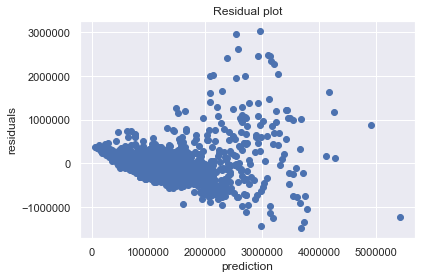

In [548]:
# Plot residuals
res = y_test - pred
plt.scatter(pred, res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

In [549]:
np.mean(cross_val_score(lasso_model_2, X_train_scaled, y_train, cv=kf, scoring = 'r2'))
# score is 0.51

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1656751790185.0, tolerance: 295802705345.3696
  positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1682665776009.25, tolerance: 299661718150.39215
  positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1643159273277.625, tolerance: 300107636125.5594
  positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1629252237446.125,

0.5527069951246608

In [550]:
lm_poly = PolynomialFeatures(degree=2) 
lm_poly.fit

<bound method PolynomialFeatures.fit of PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')>

# Feature Interactions / Polynomial

In [551]:
X_train.head()

,bldg_rating,square_feet,beds,baths,monthly_common_charges,monthly_real_estate_taxes,year,sold_season_Fall,sold_season_Spring,sold_season_Summer,sold_season_Winter,neighborhood_Beekman/Sutton Place,neighborhood_Midtown East,neighborhood_Midtown West,neighborhood_Murray Hill,neighborhood_Turtle Bay/United Nations
2194,64.0,1040.0,2.0,2.0,1390.0,1267.0,2015,0,0,0,1,0,0,0,0,1
2528,90.0,1187.0,2.0,2.0,1307.0,1221.0,2015,0,0,1,0,0,0,1,0,0
164,62.0,861.0,2.0,2.0,1067.0,775.0,2019,0,1,0,0,0,0,1,0,0
2883,62.0,484.0,0.0,1.0,502.0,317.0,2014,1,0,0,0,0,0,1,0,0
1186,78.0,624.0,0.0,1.0,417.0,582.0,2017,0,0,1,0,0,0,1,0,0


In [552]:
poly = PolynomialFeatures(degree=2) 

# Poly Transform adds new values to the tran, test, and validation sets
#X_train_poly = poly.fit_transform(X_train.values) # fits and transforms the data in one spot
X_train_poly = poly.fit_transform(X_train)
# scale is part of the model. So, need to fit to the training data. And test this fit on the 
# test data.

#X_test_poly = poly.transform(X_test.values)
X_test_poly = poly.transform(X_test)

In [553]:
# So we know what the columns are for polynomial-ized variables
poly_train_df = pd.DataFrame(poly.fit_transform(X_train), columns = poly.get_feature_names(input_features = X_train.columns))
poly_col = poly_train_df.columns

In [554]:
Poly_train_df = pd.DataFrame(poly.fit_transform(X_train), columns = poly.get_feature_names(input_features = X_train.columns))

In [572]:
# Values show that we need to scale. Model is over fit
lm_poly = LinearRegression()

kf = KFold(n_splits=10, shuffle=True, random_state = 71)
print("Mean value fom cv: ", np.mean(cross_val_score(lm_poly, X_train_poly, y_train, cv=kf, scoring='r2')))
cross_val_score(lm_poly, X_train_poly, y_train, cv=kf, scoring='r2')

Mean value fom cv:  -1.4561315017330057


array([  0.77644038, -21.8539235 ,   0.83675477,   0.73110361,
         0.83114099,   0.84987604,   0.82005902,   0.82696066,
         0.81345163,   0.80682138])

In [556]:
# Run linear Regression
lm_poly = LinearRegression()

lm_poly.fit(X_train_poly, y_train)
print("Train Score: ", lm_poly.score(X_train_poly, y_train))
print("Test Score: ", lm_poly.score(X_test_poly, y_test))

Train Score:  0.8321951867986275
Test Score:  0.8188601744467711


# Standardize Features, and run Regularization Models

In [557]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [558]:
# Fit standard scalar to the X train values to get mean and std. dev.
std = StandardScaler()
std.fit(X_train_poly)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [559]:
# Applies scalar to training set. Subtracts mean and divides by st. dev. for every value
X_tr = std.transform(X_train_poly)
X_te = std.transform(X_test_poly)

In [560]:
lasso_model = LassoCV()
lasso_model.fit(X_tr, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1495974204267.5, tolerance: 202858858363.88095
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2699141515300.375, tolerance: 202858858363.88095
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [561]:
lasso_model.alpha_

3444.1984353300295

In [565]:
print(np.mean(cross_val_score(lasso_model, X_tr, y_train, # estimator, features, target
                cv=kf, # number of folds 
                scoring='r2')))
print(cross_val_score(lasso_model, X_tr, y_train, # estimator, features, target
                cv=kf, # number of folds 
                scoring='r2'))# scoring metric

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197858503178.3125, tolerance: 165834522460.68958
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 295249930748.5625, tolerance: 168357601577.4913
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 308938193728.9375, tolerance: 158545527580.3393
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184773257048.46875, tolerance: 158545527580.3393
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1745199921066.375, tolerance: 172359146975.20605
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3111521432534.25, tolerance: 172359146975.20605
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4014756273116.375, tolerance: 172359146975.20605
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase

-1.5610857959281712


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197858503178.3125, tolerance: 165834522460.68958
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 295249930748.5625, tolerance: 168357601577.4913
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 308938193728.9375, tolerance: 158545527580.3393
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184773257048.46875, tolerance: 158545527580.3393
  tol, rng, random, positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4610278656026.75, tolerance: 172359146975.20605
  tol, rng, random, positive)


[-10.93644957   0.75581026   0.79643706   0.78573438   0.79303888]


In [563]:
lasso_model.score(X_tr, y_train)

0.7976834992563666

In [564]:
lasso_model.score(X_te, y_test)

0.7935935554875199

In [566]:
# feature_list = list(zip(poly_col, lasso_model.coef_))
# sorted(feature_list, key=lambda tup: tup[1])[:10]
# sorted(feature_list, key=lambda tup: tup[1], reverse = True)[:10]

In [569]:
std = StandardScaler()
std.fit(X_train_poly)

X_tr = std.transform(X_train_poly)
X_te = std.transform(X_test_poly)

In [570]:
np.mean(cross_val_score(lm_reg, X_tr, y_train, cv = kf, scoring = 'r2'))
#cross_val_score(lm_reg, X_tr, y_train, cv = kf, scoring = 'r2')

-1.4405690941362814

In [573]:
lm_reg = Ridge(alpha=1)
np.mean(cross_val_score(lm_reg, X_tr, y_train, cv = kf, scoring = 'r2'))

-1.5548507610509812

In [575]:
lm_reg = RidgeCV()
lm_reg.fit(X_tr, y_train)
print(lm_reg.score(X_tr, y_train))
print(lm_reg.score(X_te, y_test))

0.8186205284050022
0.8089787609491614


In [576]:
lm_reg.alpha_

10.0

In [315]:
feature_list = list(zip(poly_col, lm_reg.coef_))
sorted(feature_list, key=lambda tup: tup[1])[:10]

[('monthly_common_charges^2', -849492.750625096),
 ('square_feet^2', -561444.1031073492),
 ('monthly_common_charges neighborhood_Turtle Bay/United Nations',
  -327431.3371695097),
 ('bldg_rating beds', -325731.4845303929),
 ('bldg_rating', -301197.03692920395),
 ('square_feet', -281265.63376385014),
 ('monthly_common_charges monthly_real_estate_taxes', -252783.17343490245),
 ('square_feet sold_season_Fall', -248372.35841318924),
 ('baths^2', -233220.88800249796),
 ('square_feet year_2008', -228899.51482908067)]

In [316]:
sorted(feature_list, key=lambda tup: tup[1], reverse = True)[:10]

[('bldg_rating square_feet', 1111381.0820222727),
 ('square_feet baths', 658653.9256962996),
 ('monthly_real_estate_taxes^2', 600046.7584551148),
 ('bldg_rating apt_floor', 486316.3293835324),
 ('square_feet monthly_real_estate_taxes', 247984.25219133846),
 ('monthly_common_charges neighborhood_Murray Hill', 246890.17175465552),
 ('square_feet monthly_common_charges', 239409.4821088101),
 ('beds baths', 232616.2191177884),
 ('monthly_real_estate_taxes neighborhood_Midtown West', 201152.90510312442),
 ('bldg_rating^2', 198018.40558006425)]

# Understanding Model Performance

In [317]:
X = df_model.drop('sold_price', axis = 1)
y = df_model['sold_price']

In [318]:
X.shape

(4988, 32)

In [319]:
y.shape

(4988,)

In [320]:
plt.figure(figsize=(20,5))

rgr = LinearRegression()
rgr.fit(X,y)
pred = rgr.predict(X)

<Figure size 1440x360 with 0 Axes>

In [321]:
lm_reg = Ridge(alpha=1)
lm_reg.fit(X_tr, y_train)
pred = lm_reg.predict(X_te)

In [322]:
X_te.shape

(998, 561)

In [323]:
y_test.shape

(998,)

Text(0, 0.5, 'residuals')

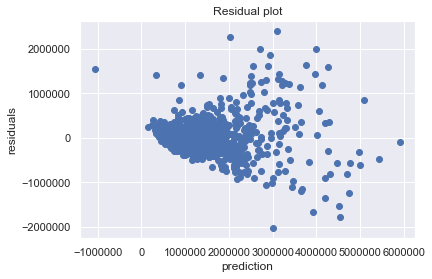

In [326]:
lm_reg = RidgeCV()
lm_reg.fit(X_tr, y_train)
pred = lm_reg.predict(X_te)

# Plot residuals
res = y_test - pred
plt.scatter(pred, res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

# res is NEGATIVE when prediction is LARGER than actual (over predicting)
# res is POSITIVE when prediction is SMALLER than actual (under predicting)

Text(0.5, 1.0, 'Normal Q-Q plot')

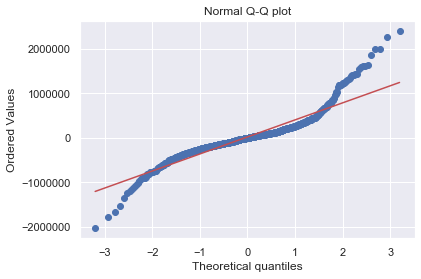

In [325]:
import scipy.stats as stats
# Plot Q-Q plot
#plt.subplot(1, 3, 3)
#Generates a probability plot of sample data against the quantiles of a 
# specified theoretical distribution 
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

# Has problems predicting really large and reall small values
# Comparing the residuals to a normal distribution
# This is HEAVY TAILED

In [ ]:
lm_reg = Ridge(alpha=1)
lm_reg.fit(X_tr, y_train)
pred = lm_reg.predict(X_te)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


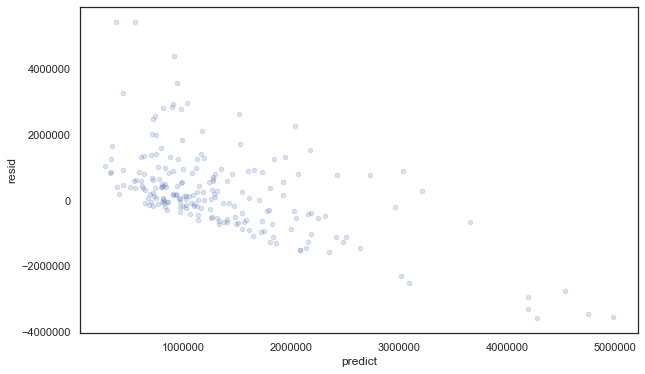

In [327]:
# Plot your predicted values on the x-axis, and your residuals on the y-axis
data = pd.DataFrame()
data['predict']= lm_reg.predict(X_te)
data['resid']= y_test - data['predict']
with sns.axes_style('white'):
    plot=data.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

# Heteroskedasticity is shown here. Residuals look like a "tornado"

In [ ]:
# Higher prediction, the more negative the residuals, meaning 
# the model is over predicting.

# Lower prediction, the more positive the residuals, meaning
# the model is under predicting.

In [124]:
# inspect histogram
#y_test[y_test < 10000000].hist(bins=25)
#plt.dist('Histogram of Dependent Variable (User Counts)');

#y_test[y_test < 10000000].hist(bins=25)
plt.dist(y_test[y_test < 10000000]);

AttributeError: module 'matplotlib.pyplot' has no attribute 'dist'

In [120]:
len(y[y < 10000000])

9190

In [121]:
len(y)

9213

In [ ]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(data['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

# Investigating Target Variable

In [85]:
df_clean.head()

,full_name,bldg_name,bldg_addr,apt_floor,bldg_rating,sold_date,sold_date_dt,sold_price,price_per_sqft,square_feet,bed_and_bath,beds,baths,url,listed,days_on_market,neighborhood,monthly_common_charges,monthly_real_estate_taxes,minimum_down_payment,doorman,last_price_change,sold_season,days_on_market
0,"Worldwide Plaza, 393 West 49th Street, #3P",Worldwide Plaza,393 West 49th Street,3.0,73.0,"Last Sold on Sep 27, 2019",2019-09-27,545000.0,NaN,NaN,"Studio, 1 bath",0.0,1.0,https://www.cityrealty.com/nyc/midtown-west/wo...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,NaN
1,"The Cosmopolitan, 145 East 48th Street, #25G",The Cosmopolitan,145 East 48th Street,25.0,78.0,"Last Sold on Sep 25, 2019",2019-09-25,799000.0,1229.0,650.0,"1 bed, 1 bath",1.0,1.0,https://www.cityrealty.com/nyc/midtown-east/th...,2019-04-12,177,Midtown East,814.0,948.0,0.1,FT Doorman,NaN,Fall,166.0
2,"The Orion, 350 West 42nd Street, #21F",The Orion,350 West 42nd Street,21.0,79.0,"Last Sold on Sep 24, 2019",2019-09-24,1085000.0,1572.0,690.0,"1 bed, 1 bath",1.0,1.0,https://www.cityrealty.com/nyc/midtown-west/th...,2019-04-12,176,Midtown West,689.0,1315.0,NaN,FT Doorman,NaN,Fall,165.0
3,"Morgan Court, 211 Madison Avenue, #6A",Morgan Court,211 Madison Avenue,6.0,73.0,"Last Sold on Sep 23, 2019",2019-09-23,1039000.0,910.0,1142.0,"1 bed, 1.5 baths",1.0,1.5,https://www.cityrealty.com/nyc/murray-hill/mor...,2019-03-06,214,Murray Hill,1683.0,1148.0,NaN,FT Doorman,NaN,Fall,201.0
4,"325 Fifth Avenue, #23F",NaN,325 Fifth Avenue,23.0,70.0,"Last Sold on Sep 23, 2019",2019-09-23,1080000.0,1570.0,688.0,"1 bed, 1 bath",1.0,1.0,https://www.cityrealty.com/nyc/murray-hill/325...,2019-05-28,132,Murray Hill,810.0,1511.0,NaN,FT Doorman,NaN,Fall,118.0


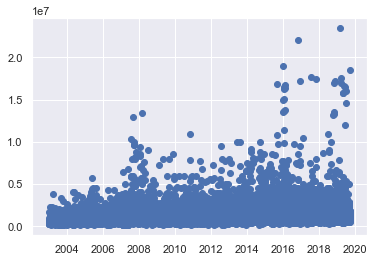

In [94]:
plt.scatter(df_clean['sold_date_dt'], df_clean['sold_price'])

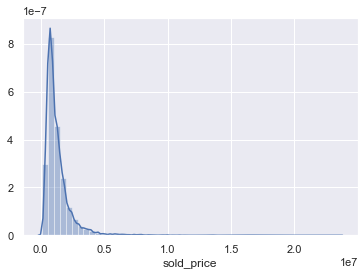

In [36]:
sns.distplot(df_clean['sold_price'])

In [99]:
len(df_clean) - len([df_clean['sold_price'] < 8000000])

14840

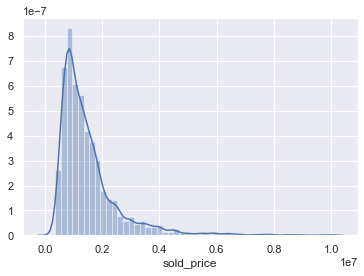

In [102]:
sns.distplot(df_model['sold_price'][df_model['sold_price'] < 10000000])